# <center> PROCESAMIENTO DIGITAL DE SEÑALES DE AUDIO</center>
## <center> Convolution FFT</center>      

In [1]:
%matplotlib inline

import math
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

import IPython.display as ipd

**NOTA:** *Las siguientes dos celdas solo son necesarias para descargar el archivo de ejemplo. Ignórelas si va a trabajar con sus propios archivos de audio.*

In [2]:
import wget

### Introducción

#### Descripción

En este ejercicio se implementa la convolución rápida usando la FFT. La convolución rápida hace uso de la convolución circular de secuencias de largo finito implementada como el producto de sus transformadas de Fourier. Se procesan tramas sucesivas de la señal de audio de entrada, se calcula el espectro de cada trama y se calcula el producto del espectro de la trama de audio con el espectro del núcleo de convolución (p. ej. la respuesta al impulso de un filtro). Luego se antitransforma el resultado y se combinan tramas sucesivas usando el métodos de Overlap-Add. 

#### Objetivo

El objetivo es lograr la simulación de espacios acústicos, haciendo la convolución de una señal de audio de entrada con la respuesta al impulso de un espacio acústico. De este modo se transfieren las características acústicas del espacio a la señal de audio (por ejemplo su reverberación), como si estuviese sonando en ese lugar.

#### Señales de audio y respuestas al impulso

Las señales de audio y las respuestas al impulso que se usan en este ejercicio provienen del proyecto OpenAir https://openairlib.net/. Las señales de audio de entrada fueron grabadas en cámara anecoica, de forma que no contengan información de espacialidad. Las respuestas al impulso (IRs) fueron grabadas en diferentes espacios acústicos. En la página del proyecto OpenAir se puede acceder a muchas otras señales de audio y IRs.

### Cómo correr el notebook
Se puede bajar y correr el notebook de forma local en una computadora.

O también se puede correr en Google Colab usando el siguiente enlace. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/audio-dsp/blob/main/notebooks/audioDSP-convolution_FFT_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Parte 1

En esta parte se cargan las señales correspondientes a la respuesta al impulso y a la señal de audio a procesar.

#### Parte 1.1

Luego de cargar la respuesta al impulso responda lo siguiente. 

1. El archivo de audio de la IR tiene dos canales. ¿Corresponde a dos respuestas al impulso?
2. Escuche la señal de audio. ¿Suena como una respuesta al impulso? 


In [3]:
# download impulse responses as audio files
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/IR_data/1st_baptist.wav?raw=true')
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/IR_data/york-minster.wav?raw=true')
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/IR_data/small-plate-01.wav?raw=true')
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/IR_data/inside-a-box.wav?raw=true')

100% [..........................................................] 23852 / 23852

'inside-a-box.wav'

In [27]:
# read the audio file of the Impulse Response (IR) (from https://openairlib.net/)
filename = '1st_baptist.wav'
# filename = 'york-minster.wav'
# filename = 'small-plate-01.wav'
# filename = 'inside-a-box.wav'

# load audio file
fs_h, h = wavfile.read(filename)

# normalize maximum (absolute) amplitude
h = h / np.max(abs(h)) * 0.9

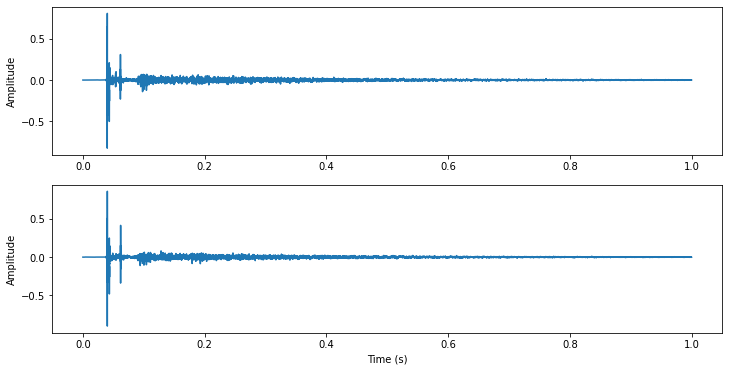

In [28]:
# time corresponding to the audio signal
time_h = np.arange(0, h.shape[0])/fs_h

# plot the two channels of the IR audio signal
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.ylabel('Amplitude')
plt.plot(time_h, h[:,0])
ax1 = plt.subplot(2, 1, 2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(time_h, h[:,1])

In [29]:
ipd.Audio([h[:,0], h[:,1]], rate=fs_h)

#### Parte 1.2

Luego de cargar la señal de audio a procesar responda lo siguiente. 

1. Escuche la señal de audio. ¿Suena como si hubiese sido grabada en algún espacio acústico en particular? 
2. ¿Cómo se generan este tipo de señales de audio? ¿Qué ocurriría con señales de audio muy reverberadas?


In [16]:
# download audio files
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/singing_voice.wav?raw=true')
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/trumpet.wav?raw=true')

100% [........................................................] 533206 / 533206

'trumpet.wav'

In [17]:
# read the anechoic audio file to process (from https://openairlib.net/)
filename = 'singing_voice.wav'
# filename = 'trumpet.wav'

# read audio file
fs, x = wavfile.read(filename)

# normalize maximum (absolute) amplitude
x = x / np.max(abs(x)) * 0.9

# check that sampling rates match
assert fs_h == fs, "Sampling frequencies do not match"

Text(0, 0.5, 'Amplitude')

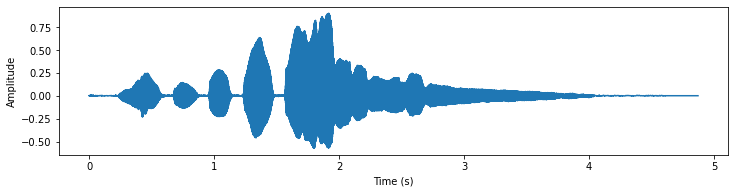

In [18]:
# time corresponding to the audio signal
time_x = np.arange(0, x.size)/fs

# plot the two channels of the IR audio signal
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(time_x, x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [19]:
ipd.Audio(x, rate=fs)

### Parte 2

Complete el código de la función `convolution_FFT`, que implementa la convolución rápida. Tenga en cuenta que la respuesta al impulso es estéreo, de modo que se obtiene una señal para el canal izquierdo y otra para el canal derecho.

Se debe completar lo siguiente:

1. Establecer el valor de $N$ (cantidad de puntos usados en la DFT), a partir del largo de una trama de la señal de entrada y la respuesta al impulso.
2. Calcular la DFT de una trama de la señal de entrada, el producto con la DFT de las IR y la DFT inversa.
3. Acumular adecuadamente la antitransformada de tramas sucesivas, de acuerdo al algoritmo de **overlap-add**.


In [33]:
def convolution_FFT(x, h, fs=22050, win=0.060):
    """ compute the convolution of a single channel input signal x and a two channel impulse response h
        using a fast implementation based on the FFT
    
    Parameters
    ----------
    x   : numpy array
          input audio file (mono) as a numpy 1D array.
    h   : numpy array
          input response audio file (stereo) as a numpy 2D array.
    fs  : float
          sampling rate.
    win : float
          window length in milliseconds.
        
    Returns
    -------
    y : numpy array
        output audio file (stereo) as a numpy 2D array.
    """
    
    # length of the input signal
    M = x.size;
    # length of the filter kernel (i.e. IR)
    K = h.shape[0]
    
    # length of the analysis window in samples
    L = int(win * fs)
    
    # number of points to compute the DFT (FFT)
    N = L + K - 1
  
    # set N to next power of 2 for FFT efficiency
    nextPower2 = math.ceil(math.log(N,2))
    N = int(math.pow(2, nextPower2))
    
    # DFT of the IRs
    H = np.zeros((N, 2), dtype = complex) # two channels (defined as complex to avoid warnings)
    H[:, 0] = np.fft.fft(h[:,0], N) # left channel
    H[:, 1] = np.fft.fft(h[:,1], N) # right channel
    
    # total number of analysis frames
    num_frames = int(np.floor(M / L))

    # initialize output frame
    yr = np.zeros((N, 2))
    # initialize DFT of frame
    Yr = np.zeros((N, 2), dtype = complex) # two channels (defined as complex to avoid warnings)
    # initialize whole output signal
    y = np.zeros(((num_frames - 1) * L + N + K - 1, 2))
    
    # process each frame
    for ind in range(num_frames):

        # initial and ending points of the frame
        n_ini = int(ind * L)
        n_end = n_ini + L

        # signal frame
        xr = x[n_ini:n_end]

        # DFT of the signal frame
        Xr = np.fft.fft(xr, N)

        # product of the DFTs
        Yr[:, 0] = H[:,0] * Xr   # left channel
        Yr[:, 1] = H[:,1] * Xr   # right channel

        # inverse DFT (real part is taken since complex part should be zero)
        yr[:, 0] = np.fft.ifft(Yr[:, 0]).real    # left channel
        yr[:, 1] = np.fft.ifft(Yr[:, 1]).real    # right channel
        
        # overlap-add
        y[n_ini:n_ini+N, 0] += yr[:, 0] # left channel
        y[n_ini:n_ini+N, 1] += yr[:, 1] # right channel
          
    # normalize output amplitude to match input amplitude
    max_in = np.max(np.abs(x))
    max_out = np.max(np.abs(y))
    y = y * max_in / max_out                  
   
    return y

### Parte 3

Una vez completada la implementación de la función `convolution_FFT` siga los siguientes pasos.

1. Ejecute la función `convolution_FFT` para una cierta señal de audio de entrada y una cierta respuesta al impulso. Escuche el resultado de la convolución y grafique la señal de audio obtenida. Compare con la señal de audio original.
2. Estime el tiempo que demora el proceso usando la función `time.time()`. 
3. Repita el proceso pero sin usar un valor de $N$ que sea potencia de 2 (comente el bloque de código que usa `nextPower2` para establecer el valor de $N$). Compare los tiempos de ejecución. ¿Hay alguna diferencia?

In [34]:
# compute the convolution using the FFT implementation
t = time.time()

y_FFT = convolution_FFT(x, h)

elapsed = time.time() - t

print(elapsed)

0.24805593490600586


In [35]:
ipd.Audio([y_FFT[:, 0], y_FFT[:, 1]], rate=fs)

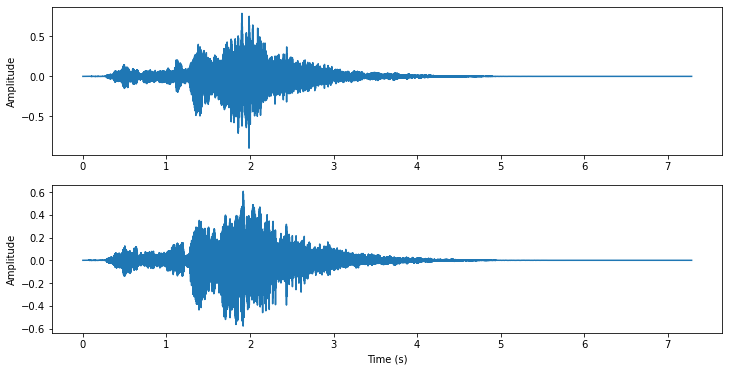

In [36]:
# time corresponding to the output signal
time_y_FFT = np.arange(0, y_FFT.shape[0])/fs

# plot the two channels of the output signal
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.ylabel('Amplitude')
plt.plot(time_y_FFT, y_FFT[:, 0])
ax1 = plt.subplot(2, 1, 2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(time_y_FFT, y_FFT[:, 1])

### Parte 4

La función `convolution_TEMP1` implementa la convolución de las señales en el dominio del tiempo. Analice la implementación y responda las siguientes preguntas. 

1. ¿Por qué se usa la función `flip` de `numpy`?
2. ¿Para qué se usa el arreglo `u` (`numpy array`)?
3. ¿Es posible implementar una función más eficiente para la convolución en el tiempo? ¿Cómo?

In [37]:
def convolution_TEMP1(x, h):
    """ compute the convolution of a single channel input signal x and a two channel impulse response h
    
    Parameters
    ----------
    x   : numpy array
          input audio file (mono) as a numpy 1D array.
    h   : numpy array
          input response audio file (stereo) as a numpy 2D array.
        
    Returns
    -------
    y : numpy array
        output audio file (stereo) as a numpy 2D array.
    """
    
    # length of the input signal
    M = x.size;
    # length of the filter kernel (i.e. IR)
    K = h.shape[0]
    
    # total length of the output signal
    T = M + K - 1
    
    # initialize whole output signal
    y = np.zeros((T, 2))

    # initialize auxiliary array
    u = np.zeros(T + K - 1)
    u[K-1:K-1+M] = x

    # flip kernel (left and right channels)
    h_l = np.flip(h[:, 0])
    h_r = np.flip(h[:, 1])    
   
    # compute the convolution
    for t in range(T):

        # initialize auxiliary array for filter kernel (left channel)
        v = np.zeros(T + K - 1)
        v[t:t+K] = h_l
        # compute output (left channel)
        y[t, 0] = u @ v

        # initialize auxiliary array for filter kernel (right channel)
        v = np.zeros(T + K - 1)
        v[t:t+K] = h_r
        # compute output (right channel)
        y[t, 1] = u @ v
                
    # normalize output amplitude to match input amplitude
    max_in = np.max(np.abs(x))
    max_out = np.max(np.abs(y))
    y = y * max_in / max_out
                     
    return y

### Parte 5

Una vez analizada la implementación de la función `convolution_TEMP1` se sugiere realizar lo siguiente.

1. Ejecute la función `convolution_TEMP1` para la misma señal de audio de entrada y la misma respuesta al impulso usadas antes. Escuche el resultado de la convolución y grafique la señal de audio obtenida. Compare con la señal de audio original y con la obtenida con la convolución rápida.
2. Estime el tiempo que demora el proceso usando la función `time.time()`. 
3. Compare el tiempo de ejecución con el obtenido usando la convolución rápida (`convolution_FFT`). ¿Hay alguna diferencia?

In [38]:
# compute the convolution using the direct implementation in time (version 1)
t = time.time()

y_TEMP1 = convolution_TEMP1(x, h)

elapsed = time.time() - t

print(elapsed)

41.96497082710266


In [39]:
ipd.Audio([y_TEMP1[:, 0], y_TEMP1[:, 1]], rate=fs)

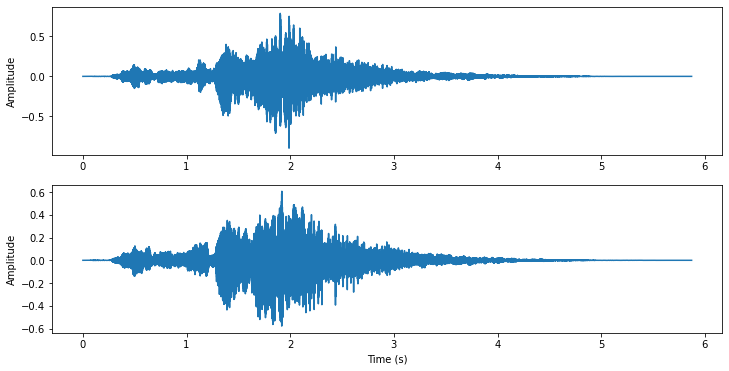

In [40]:
# time corresponding to the output signal
time_y_TEMP1 = np.arange(0, y_TEMP1.shape[0])/fs

# plot the two channels of the output signal
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.ylabel('Amplitude')
plt.plot(time_y_TEMP1, y_TEMP1[:, 0])
ax1 = plt.subplot(2, 1, 2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(time_y_TEMP1, y_TEMP1[:, 1])

### Parte 6

La función `convolution_TEMP2` también implementa la convolución de las señales en el dominio del tiempo. Analice la implementación y responda las siguientes preguntas. 

1. ¿Qué representan los índices `x_ini` y `x_end`?
2. ¿Qué representan los índices `h_ini` y `h_end`?
3. ¿Cree que esta implementación es más o menos eficiente que la anterior (`convolution_TEMP1`)? ¿Por qué?

In [41]:
def convolution_TEMP2(x, h):
    """ compute the convolution of a single channel input signal x and a two channel impulse response h
    
    Parameters
    ----------
    x   : numpy array
          input audio file (mono) as a numpy 1D array.
    h   : numpy array
          input response audio file (stereo) as a numpy 2D array.
        
    Returns
    -------
    y : numpy array
        output audio file (stereo) as a numpy 2D array.
    """
    
    # length of the input signal
    M = x.size;
    # length of the filter kernel (i.e. IR)
    K = h.shape[0]
    
    # total length of the output signal
    T = M + K - 1
    
    # initialize whole output signal
    y = np.zeros((T, 2))
    
    # flip kernel (left and right channels)
    h_l = np.flip(h[:, 0])
    h_r = np.flip(h[:, 1])    
  
    # compute the convolution
    for t in range(T):

        # initial and ending index for input signal
        x_ini = max(0, t + 1 - K)
        x_end = min(t + 1, M)

        # initial and ending index for filter kernel
        h_ini = max(0, K - t - 1)
        h_end = min(K, M + K - t - 1)
        
        # compute output (left and right channel)
        y[t, 0] = x[x_ini:x_end] @ h_l[h_ini:h_end]
        y[t, 1] = x[x_ini:x_end] @ h_r[h_ini:h_end]
              
    # normalize output amplitude to match input amplitude
    max_in = np.max(np.abs(x))
    max_out = np.max(np.abs(y))
    y = y * max_in / max_out
                     
    return y

### Parte 7

Una vez analizada la implementación de la función `convolution_TEMP2` se sugiere realizar lo siguiente.

1. Ejecute la función `convolution_TEMP2` para la misma señal de audio de entrada y la misma respuesta al impulso usadas antes. Escuche el resultado de la convolución y grafique la señal de audio obtenida. Compare con la señal de audio original y con la obtenida con la convolución rápida.
2. Estime el tiempo que demora el proceso usando la función `time.time()`. 
3. Compare el tiempo de ejecución con el obtenido usando la función `convolution_TEMP1`. ¿Hay alguna diferencia?

In [42]:
# compute the convolution using the direct implementation in time (version 2)
t = time.time()

y_TEMP2 = convolution_TEMP2(x, h)

elapsed = time.time() - t

print(elapsed)

5.017859935760498


In [43]:
ipd.Audio([y_TEMP2[:, 0], y_TEMP2[:, 1]], rate=fs)

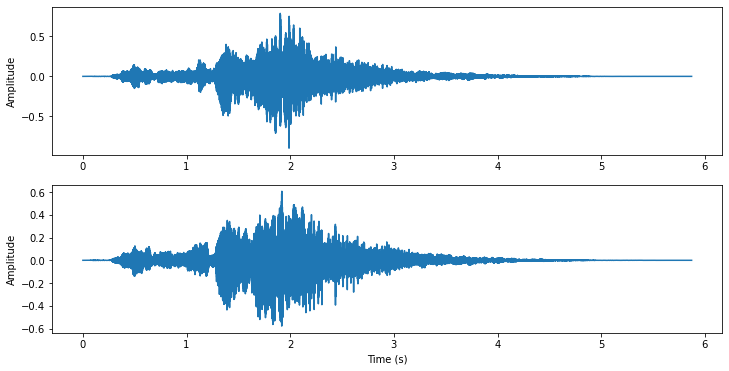

In [44]:
# time corresponding to the output signal
time_y_TEMP2 = np.arange(0, y_TEMP2.shape[0])/fs

# plot the two channels of the output signal
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.ylabel('Amplitude')
plt.plot(time_y_TEMP2, y_TEMP2[:, 0])
ax1 = plt.subplot(2, 1, 2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(time_y_TEMP2, y_TEMP2[:, 1])

### Parte 8

Por último tiene sentido comparar en detalle las señales obtenidas. Para estoo se sugiere sumar el valor absoluto de la diferencia de las tres señales calculadas (`y_FFT`, `y_TEMP1` e `y_TEMP2`). 

**Nota:** tenga en cuenta que el largo de las señales puede no ser el mismo. 

Una vez hecha la comparación responda las siguientes preguntas.

1. ¿Cuál es la diferencia entre las señales obtenidas usando `convolution_TEMP1` y `convolution_TEMP2`? 
2. ¿De qué orden es el ruido de las operaciones? ¿Cuántas muestras tiene la señal?
2. ¿Cuál es la diferencia entre las señales obtenidas usando `convolution_FFT` y `convolution_TEMP1`? 
3. ¿Qué implementación realiza menos operaciones `convolution_FFT` o `convolution_TEMP1`? 
4. ¿Qué implementación cree que acumula menos ruido de operaciones? ¿Qué implementación es más precisa?

In [45]:
print(y_FFT.shape, y_TEMP1.shape, y_TEMP2.shape)

(160660, 2) (129487, 2) (129487, 2)


In [46]:
print(abs(y_TEMP1-y_TEMP2).sum())

3.844147230511735e-11


In [47]:
print(abs(y_FFT[y_TEMP1.shape[0]] - y_TEMP1).sum())

9920.595995573993


In [48]:
print(abs(y_FFT[y_TEMP1.shape[0]] - y_TEMP2).sum())

9920.595995574024
